# **Fast-Gamma : speed benchmarking**

This notebook aims to highlight the significance of the gain of speed of fast-gamma compared to the classic gamma algorithm, as well as the uncertainty of 
the loss of precision when using this algorithm.

## **1.** Speed gains of fast-gamma

In [4]:
import random

import pygamma_agreement as pa
import matplotlib.pyplot as plt
from typing import Iterable
import numpy as np
import logging
from time import time
from tqdm import tqdm

start = time()
np.random.seed(4775)

def random_continuum(nb_annotators: int, avg_nb_annotations: int) -> pa.Continuum:
    sampler = pa.StatisticalContinuumSampler()
    sampler.init_sampling_custom(annotators=['Ref'],
                                 avg_num_units_per_annotator=avg_nb_annotations, std_num_units_per_annotator=0,
                                 avg_duration=5, std_duration=2,
                                 avg_gap=3, std_gap=2,
                                 categories=np.array([str(i) for i in range(4)]))
    reference = sampler.sample_from_continuum
    cst = pa.CorpusShufflingTool(0.3, reference)
    continuum = cst.corpus_shuffle(nb_annotators, shift=True, cat_shuffle=True)
    
    return continuum



def benchmark_gamma_time(nb_annotators: int, iter_nb_annot: Iterable[int]) -> float:
    times_gamma = []
    times_fast = []
    nb_annot = []
    error = []
    for nb_annotations in tqdm(iter_nb_annot):
        continuum = random_continuum(nb_annotators, nb_annotations)

        dissim = pa.CombinedCategoricalDissimilarity(continuum.categories, alpha=3, beta=1, delta_empty=1)

        # same seed is necessary for both algorithms to ensure the same samples are used.
        seed = np.random.randint(0, 10000)
        
        # Gamma
        np.random.seed(seed)
        bp = time()
        gamma = continuum.compute_gamma(dissim, fast=False).gamma
        times_gamma.append(time() - bp)

        # Fast-Gamma
        np.random.seed(seed)
        bp = time()
        fast_gamma = continuum.compute_gamma(dissim, fast=True).gamma
        times_fast.append(time() - bp)
        
        error.append(abs(gamma - fast_gamma))
        nb_annot.append(nb_annotations)

    # Figure
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.set_xlabel('average number of annotations per annotator')
    ax.set_ylabel('Time to compute gamma (seconds)')
    ax.plot(nb_annot, times_gamma, label="Gamma, fast disabled", color="blue", marker="o")
    ax.plot(nb_annot, times_fast, label="Gamma, fast enabled", color="green", marker="o")
    plt.legend(loc='upper left', frameon=False)
    plt.show()
    return float(np.mean(error))

### **1.1.** 2 annotators

* Average look of a  random continuum used for this benchmarking :

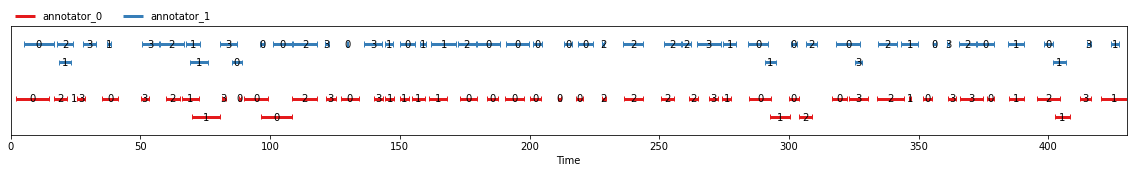

In [7]:
pa.show_continuum(random_continuum(2, 50))

100%|██████████| 17/17 [32:44<00:00, 115.55s/it]


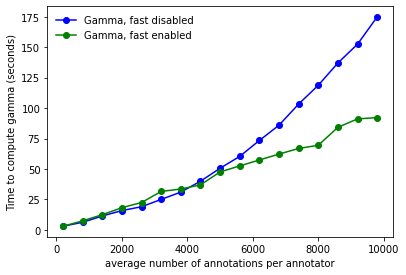

Average error of fast_gamma : 1.325735400740037e-06


In [2]:
logging.getLogger().disabled = True
print(f"Average error of fast_gamma : {benchmark_gamma_time(2, range(200, 10000, 600))}")

We can see here that with **2 annotators**, the gain of speed of soft-gamma is not significant enough when each annotator has on **average less than $\simeq 5000$ annotations**.
The algorithm does, in fact, **detects this beforehand and uses the normal gamma algorithm**. Otherwise, the fast-gamma gives significant speed gains with a high number of annotations per annotator.  
Precision is still more than satisfactory with fast-gamma on the realistic-looking 

### **1.2.** 3 annotators

* Average look of a  random continuum used for this benchmarking :

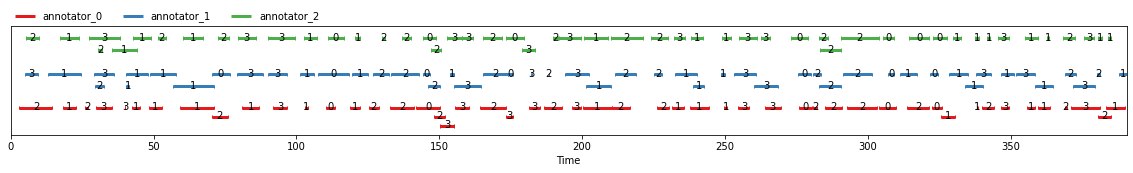

In [9]:
pa.show_continuum(random_continuum(3, 50))

In [ ]:
# 3 annotators:
logging.getLogger().disabled = True
print(f"Average error of fast_gamma : {benchmark_gamma_time(3, range(50, 525, 30))}")

Although the precision is a bit less satisfying than with 2 annotators, **the gain of speed is much more significant**. While it takes a certain number of annotations for fast-gamma to be faster with 2 annotators, it becomes **instantly indispensable when the number of annotators increase**

## **2.** precision of fast-gamma

In this section, we'll try to establish empirically that the precision of fast-gamma is more than reliable in real scenarios.

In [9]:
def precision(n: int, nb_sample: int):
    overlapping = []
    error = []
    fast_gamma_results = []
    for i in tqdm(range(2*n + 1)):
        duration = 5

        sampler = pa.StatisticalContinuumSampler()
        sampler.init_sampling_custom(annotators=['Ref'],
                                     avg_num_units_per_annotator=50, std_num_units_per_annotator=0,
                                     avg_duration=duration, std_duration=2,
                                     avg_gap=(-duration) + duration * (i / n), std_gap=2,
                                     categories=np.array([str(i) for i in range(4)]))
        reference = sampler.sample_from_continuum
        cst = pa.CorpusShufflingTool(0.1, reference)
        continuum = cst.corpus_shuffle(["martin", "martino", "martine"], shift=True, cat_shuffle=True)

        dissim = pa.CombinedCategoricalDissimilarity(alpha=3, beta=1, delta_empty=1)
        sampled_error = []
        for _ in range(nb_sample):
            seed = np.random.randint(0, 10000)
            # Gamma
            np.random.seed(seed)
            gamma = continuum.compute_gamma(dissim, fast=False, sampler=pa.ShuffleContinuumSampler()).gamma

            # Fast-Gamma
            np.random.seed(seed)
            fast_gamma = continuum.compute_gamma(dissim, fast=True, sampler=pa.ShuffleContinuumSampler())
            sampled_error.append(abs(gamma - fast_gamma.gamma))
        fast_gamma_results.append(fast_gamma)
        
        overlapping.append(i/(n//2))
        error.append(np.mean(sampled_error))
    # Figure
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Overlapping of units')
    ax.set_xlim([overlapping[0] * 1.1, overlapping[-1] * 1.1])
    ax.set_ylabel('Error rate')
    ax.plot(overlapping, error, color="blue", marker="o")
    plt.show()
    
    pa.show_continuum(max(zip(error, fast_gamma_results), key=(lambda x: x[1].gamma)))
    

In [ ]:
logging.getLogger().disabled = True
precision(20, 1)

  2%|▏         | 1/41 [00:59<39:38, 59.45s/it]

def fastgamma_windowing(num_units: int, nb_annotators: int, windows: Iterable(int)):
    # We use the statistical continuum sampler to create a reference for the cst.
    nb_annotators = 3
    num_units = 500

    n = num_units
    p = nb_annotators

    sampler = pa.StatisticalContinuumSampler()
    sampler.init_sampling_custom(annotators=['Ref'],
                                 avg_num_units_per_annotator=num_units, std_num_units_per_annotator=0,
                                 avg_duration=100, std_duration=25,
                                 avg_gap=0, std_gap=25,
                                 categories=np.array([str(i) for i in range(4)]))
    # Compilation
    continuum = sampler.sample_from_continuum
    cst = pa.CorpusShufflingTool(0.3, continuum)
    cont_cst = cst.corpus_shuffle([f"annotator_{i}" for i in range(nb_annotators)], shift=True, cat_shuffle=True, )
     #pa.show_continuum(cont_cst)
    dissim = pa.CombinedCategoricalDissimilarity(continuum.categories, alpha=3, beta=1, delta_empty=1.0)
    smallest_window = cont_cst.get_first_window(dissim, 1)
    smallest_window.get_best_alignment(dissim)
    s = smallest_window.max_num_annotations_per_annotator - 1
    print(s)

    times = []
    window_sizes = []
    for window_size in tqdm(range(3, 100, 3)):
        n_pts = 3
        times_ws = []
        disorders = []
        aligments = []
        copy = cont_cst.copy()
        bp = process_time_ns()
        while copy:
            window = copy.get_first_window(dissim, window_size)
            for chosen in window.get_best_alignment(dissim).n_leftmost(window_size):
                for annotator, unit in chosen.n_tuple:
                    aligments.append(chosen)
                    disorders.append(chosen.disorder)
                    if unit is not None:
                        copy.remove(annotator, unit)
        times.append((process_time_ns() - bp))
        window_sizes.append(window_size)

    times = np.array(times)
    times *= 1000000
    window_sizes = np.array(window_sizes)

    fig: plt.Figure
    ax: plt.Axes
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.set_xlabel('Window size')
    ax.set_ylabel('Time to compute (s)')

    def f(w): # Complexity of fast-gamma, depending on the window size.
        return ((n - w) * p / 2 + 2 * p + (w + s * p) * p  # getting first window
                + (n - w) * p / 2 + 1 / 20 * (w + s) ** p  # getting best alignment ( times numba factor)
                + (w + s) * p * np.log2((w + s) * p) + w * p  # getting the w leftmost alignments & adding them
                ) * (n / w)

    # adding the log factorial corresponds to the emptying-the-continuum-unit-by-unit time.
    logfactorials = np.log2(window_sizes)
    for i in range(1, len(logfactorials)):
        logfactorials[i] += logfactorials[i - 1]

    interpol = f(window_sizes) + p * logfactorials

    # Rescaling interpolation function
    interpol *= np.mean([times[i] / f(window_sizes[i]) for i in range(len(window_sizes))])

    ax.plot(window_sizes, times, color='green', label='Fast-gamma real time')
    ax.plot(window_sizes, interpol, color='gray', linestyle='dotted', label='Fast-gamma estimation (re-scaled)')

    ax.legend(loc='upper center')
    plt.show()

.